In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from collections import namedtuple 

Suppose we are dealing with some stairs defined by:

In [10]:
stair_width = 30
stair_height = 20

Let's plot them:

In [22]:
def plot_stairs(x, y, num_climbs=1):
    for i in range(num_climbs):
        plt.plot([x, x+stair_width], [y, y], 'b')
        x += stair_width
        plt.plot([x, x], [y, y+stair_height], 'b')
        y += stair_height

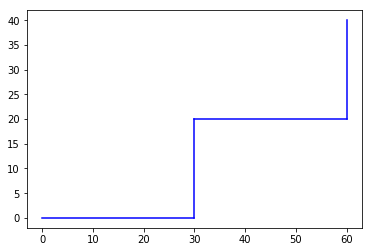

In [23]:
plot_stairs(0, 0, 2)
plt.show()

We will search for shapes parameterized by an array of radii, $r$, spanned over an angular region of size $\Delta\theta$, which is repeated for $n$ times inside a $2\pi$ region.

opt_res:      fun: 19.124772798205086
     jac: array([ -5.6329298 ,   4.98497438,   0.09491396,   0.09875035,
         0.10332537,   0.10930014,   0.10695481,   0.11074495,
        19.73826361, -18.81060266,   9.97913289])
 message: 'Optimization terminated successfully.'
    nfev: 312
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([23.10680729, 25.26944884, 27.02147619, 28.48593892, 29.7212047 ,
       30.75871467, 31.6164015 , 32.30447406, 32.82805749, 33.18858628,
        0.47759503])
Angle0 -0.5622768938908421
Angle0 -1.039035228250522


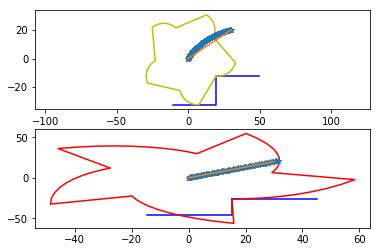

In [9]:
class WheelGeometry:
    def __init__(self, r, Dtheta, n):
        self.r = r
        self.Dtheta = Dtheta
        self.n = n
        
    @cached_property
    def rp(self):
        
WheelGeometry = namedtuple('WheelGeometry', ['r', 'rp', 'R', 'Dtheta', 'curve_length', 'segm_count', 'theta_step', 'chunk_lengths'])


def make_geometry(r, Dtheta, segm_count):
    assert 1 == r.ndim
    if r.dtype is np.dtype(int):
        r = np.array(r, dtype=float)


    theta_step = Dtheta/(r.size - 1)
    rp = (r[1:] - r[0:-1])/theta_step

    R = np.sqrt(r[0:-1]**2 + rp**2)

    chunk_lengths = np.sqrt(r[0:-1]**2 + r[1:]**2 - 2*np.cos(theta_step)*r[0:-1]*r[1:])
    curve_length = np.sum(chunk_lengths)

    return WheelGeometry(r, rp, R, Dtheta, curve_length, segm_count, theta_step, chunk_lengths)


def compute_constraints(g, stair_width, stair_height):
    alpha_0 = compute_backward_angle(g.r[0], g.r[1], g.theta_step)
    alpha_1 = compute_angle(g.r[-2], g.r[-1], g.theta_step)

    Dalpha = alpha_1 - alpha_0
    c0 = g.curve_length - np.cos(alpha_1)*g.r[-1] + np.cos(alpha_0)*g.r[0] - stair_width
    c1 = g.r[-1]*np.sin(alpha_1) - g.r[0]*np.sin(alpha_0) - stair_height

    c2 = g.Dtheta + Dalpha - 2*np.pi/g.segm_count

    return np.array([c0, c1, c2])


def plot_wheel(g, *args, **kwargs):
    if not args:
        args = ('b',)

    if 'transform' in kwargs:
        transform = kwargs['transform']
    else:
        transform = np.eye(3)

    xx, yy = [], []
    thetas_one_segm = np.linspace(0, g.Dtheta, g.r.size)
    for i in range(g.segm_count):
        thetas = thetas_one_segm + i*2*np.pi/g.segm_count
        x = g.r*np.cos(thetas)
        y = g.r*np.sin(thetas)
        
        joined = np.concatenate(([x], [y], np.ones((1, x.size))))
        transformed = transform.dot(joined)
    
        x = transformed[0, :]
        y = transformed[1, :]

        xx.append(x)
        yy.append(y)

        if i == 0:
            stair_args = ([x[0] - stair_width, x[0], x[0], x[0] + stair_width], [y[0]-stair_height, y[0] - stair_height, y[0], y[0]], 'b')

    x = np.concatenate(xx)
    x = np.append(x, x[0])
    y = np.concatenate(yy)
    y = np.append(y, y[0])
    plt.plot(*stair_args)
    plt.plot(x, y, *args)
    plt.plot(0, 0, 'r*')

def compute_angle(r0, r1, dtheta):
    r2 = np.sqrt(r0**2 + r1**2 - 2*np.cos(dtheta)*r0*r1)
    sin_angle = np.sin(dtheta) * r0/r2
    cos_angle = (r1**2 + r2**2 - r0**2)/(2*r1*r2)
    return np.arctan2(sin_angle, cos_angle)

def compute_backward_angle(r0, r1, dtheta):
    return dtheta + compute_angle(r0, r1, dtheta)

def constr(arr):
    return compute_constraints(make_geometry(arr[:-1], arr[-1], segm_count), stair_width, stair_height)

def lerp(a, b, s):
    return s*b + (1-s)*a

def centre_points(g):
    bwd_angles = compute_backward_angle(g.r[:-1], g.r[1:], g.theta_step)
    fwd_angles = compute_angle(g.r[:-1], g.r[1:], g.theta_step)

    steps = 10
    result = np.empty((2, 0), dtype=g.r.dtype)
    l = np.cumsum(g.chunk_lengths)
    for i in range(g.r.size-2):
        fwd_angle = fwd_angles[i]
        bwd_angle = bwd_angles[i+1]
        pos_angles = np.pi - lerp(fwd_angle, bwd_angle, np.linspace(0, 1, steps))
        pos = np.array([g.r[i+1]*np.cos(pos_angles) + l[i], g.r[i+1]*np.sin(pos_angles)])
        result = np.concatenate((result, pos), 1)

    return result - np.repeat(np.array([result[:, 0]]).T, result.shape[1], 1)

def dist_to_line_sqr(p, x0, y0, x1, y1):
    normer = np.array([y0-y1, x1-x0, x0*y1-x1*y0])
    p_extended = np.concatenate((p, np.ones((1, p.shape[1]))), 0)
    distances = normer.dot(p_extended)
    return np.abs(distances)

def objective(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    r = arr[:-1]
    theta_step = g.Dtheta/(r.size - 1)
    segments = np.sqrt(r[0:-1]**2 + r[1:]**2 - 2*np.cos(theta_step)*r[0:-1]*r[1:])
    segments2b2 = np.sqrt(r[0:-2]**2 + r[2:]**2 - 2*np.cos(2*theta_step)*r[0:-2]*r[2:])
    angles = np.arccos((segments[0:-1]**2 + segments[1:]**2 - segments2b2**2)/(2*segments[0:-1]*segments[1:]))
    path = centre_points(g)
    distances = dist_to_line_sqr(path, 0, 0, stair_width, stair_height)
    # return -sum(g.r**2)
    # return 0*np.sum(distances**2) + 1*max(np.pi - angles)
    # return abs(poly_area(path[0, :], path[1, :])) + 0.0*max(np.pi-angles)
    #return 1*work_obj(arr) + 0* max(np.pi - angles)*(stair_width*stair_height)
    return squared_diff_obj(arr) + 0.9 * max(np.pi - angles)*(stair_width*stair_height)

def poly_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def work_obj(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    path = centre_points(g)

    y_diffs = path[1, 1:] - path[1, :-1]
    return sum(abs(y_diffs)) 

def squared_diff_obj(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    path = centre_points(g)

    x_diffs = path[0, 1:] - path[0, :-1]

    ys_ideal = stair_height/stair_width * path[0, :]

    return np.sum((path[1, :-1])**2*x_diffs)

def length_obj(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    path = centre_points(g)

    path_segments = path[:, 1:] - path[:, :-1]

    return np.sum(path_segments[1, :]**2 + path_segments[0, :]**2)

def max_slope_obj(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)

    path = centre_points(g)

    path_segments = path[:, 1:] - path[:, :-1]

    dy = path_segments[1, :]
    dx = path_segments[0, :]

    return np.max(np.abs(dy/(np.abs(dx) + 0.00001*np.sqrt(np.sum(dx**2/dx.size)))))

def area_obj(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    path = centre_points(g)
    distances = dist_to_line_sqr(path, 0, 0, stair_width, stair_height)
    # return -sum(g.r**2)
    return abs(poly_area(path[0, :], path[1, :]))
    

def curve_length(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    return stair_width*0.6 - g.curve_length

def chunk_areas(arr):
    g = make_geometry(arr[:-1], arr[-1], segm_count)
    c = np.cos(g.theta_step)
    s = np.sin(g.theta_step)
    c2 = np.cos(2*g.theta_step)
    s2 = np.sin(2*g.theta_step)

    r = g.r

    return r[:-2]*(s*r[1:-1] - s2*r[2:]) + r[1:-1]*r[2:]*(c*s2 - c2*s)

#r0 = np.random.rand(10) * stair_width/4 + stair_width*3/4
r0 = stair_width*np.exp(stair_height/stair_width * np.linspace(0, 1, 10))
Dtheta0 = 1
x0 = np.append(r0, Dtheta0)

cons = {'type': 'eq', 'fun': constr}
cons_length = {'type': 'ineq', 'fun': curve_length}
cons_convex = {'type': 'ineq', 'fun': chunk_areas}

bounds_constr = optimize.Bounds(0.1, np.append(np.repeat(100, r0.size), 2*np.pi/segm_count))

obj = length_obj
opt_res = optimize.minimize(obj, x0, bounds=bounds_constr, constraints=(cons, cons_length, cons_convex))
x_star = opt_res.x
print("opt_res:", opt_res)

# print(constr(x_star))

g_0 = make_geometry(r0, Dtheta0, segm_count)
g_star = make_geometry(x_star[:-1], x_star[-1], segm_count)

def plot_wheel_and_stair(g, *args):
    if not args:
        args = ('b',)

    angle0 = - compute_backward_angle(g.r[0], g.r[1], g.theta_step)
    print("Angle0", angle0)

    t = np.array([[np.cos(angle0), -np.sin(angle0), 0], [np.sin(angle0), np.cos(angle0), 0], [0, 0, 1]])

    plot_wheel(g, transform=t, *args)
    path = centre_points(g)
    plt.plot(path[0, :], path[1, :], '*-')
    plt.plot([0, stair_width], [0, stair_height])

def plot_stairs():
    x = -1
    y = -4

    for i in range(3):
        plt.plot([x, x+stair_width], [y, y], 'b')
        x += stair_width
        plt.plot([x, x], [y, y+stair_height], 'b')
        y += stair_height

plt.subplot(2, 1, 1)
plot_wheel_and_stair(g_star, 'y')
plt.axis('equal')

plt.subplot(2, 1, 2)
plot_wheel_and_stair(g_0, 'r')
plt.show()
